### Deskripsi Tugas
Proyek ini mengimplementasikan perbandingan komprehensif antara tigas model Vision Transformer:
1. `DeiT Base` : `deit_base_patch16_224`,       # ~86M Params
2. `ViT Base` : `vit_base_patch16_224`,         # ~86M Params
3. `Swin Base` : `swin_base_patch4_window7_224` # ~88M Params

### Dataset yang digunakan adalah STL-10
- **Original Split**: 5000 train, 8000 test images
- **Custom Split**: 4000 train, 1000 validation, 8000 test
- **Kelas**: 10 (airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck)
- **Besar Gambar**: 224×224 (bicubic resize)


# Import Library dan Setup Hardware

In [ ]:
import os
import time
import gc
import psutil
import random
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import STL10
import timm
from timm import create_model
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                           confusion_matrix, classification_report)
import warnings

# Setup Tampilan & Warning
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Random Seed untuk Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True # True bagus untuk GPU modern (A100/A40)

set_seed(42)

# Cek Hardware
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_hardware_info():
    info = {
        "Device": device.type.upper(),
        "GPU Name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A",
        "VRAM Total": f"{torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB" if torch.cuda.is_available() else "N/A",
        "CPU Cores": psutil.cpu_count(),
        "System RAM": f"{psutil.virtual_memory().total / 1024**3:.2f} GB"
    }
    return info

hw_info = get_hardware_info()
print(f"\n[HARDWARE INFO]\n{hw_info}")


[HARDWARE INFO]
{'Device': 'CUDA', 'GPU Name': 'NVIDIA A40', 'VRAM Total': '44.42 GB', 'CPU Cores': 96, 'System RAM': '503.51 GB'}


# Setup Hyperparameter dan Output Direktori

In [ ]:
# Hyperparameters (Disesuaikan untuk GPU A40)
BATCH_SIZE = 64      # Aman untuk model Base di GPU 40GB+
NUM_WORKERS = 8      # Optimal untuk 9 vCPU
EPOCHS = 20          # Jumlah epoch training
LR = 3e-5            # Learning rate kecil untuk fine-tuning model besar
IMG_SIZE = 224

# Daftar Model (Varian BASE)
MODELS_CONFIG = {
    'DeiT Base': 'deit_base_patch16_224',       # ~86M Params
    'ViT Base':  'vit_base_patch16_224',         # ~86M Params
    'Swin Base': 'swin_base_patch4_window7_224' # ~88M Params
}

# Setup Direktori Output
BASE_OUTPUT_DIR = "./training_results"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, f"run_{timestamp}")

os.makedirs(f"{OUTPUT_DIR}/weights", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/plots", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/logs", exist_ok=True)

print(f"\n[OUTPUT] Hasil akan disimpan di: {OUTPUT_DIR}")


[OUTPUT] Hasil akan disimpan di: ./training_results/run_20251121_134130


# Define Data Transform

In [ ]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Augmentasi Data
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

print("\n[DATA] Loading STL-10 Dataset...")
train_full = STL10(root='./data', split='train', download=True, transform=train_transform)
test_ds = STL10(root='./data', split='test', download=True, transform=val_test_transform)

# Split Train/Val (80% Train, 20% Val)
train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_ds, val_ds = random_split(train_full, [train_size, val_size])
# Override val transform
val_ds.dataset.transform = val_test_transform

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, pin_memory=True)

class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


[DATA] Loading STL-10 Dataset...


# Model Param

In [ ]:
def get_model_parameters(model):
    """Poin A: Menghitung detail parameter & ukuran model"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable = total_params - trainable_params
    
    # Hitung ukuran MB
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / 1024**2
    
    return total_params, trainable_params, non_trainable, size_mb

def save_checkpoint(model, model_name, acc, epoch, is_best=False):
    """Menyimpan file .pth"""
    state = {'epoch': epoch, 'state_dict': model.state_dict(), 'best_acc': acc}
    # Save Last
    torch.save(state, f"{OUTPUT_DIR}/weights/{model_name}_last.pth")
    # Save Best
    if is_best:
        torch.save(state, f"{OUTPUT_DIR}/weights/{model_name}_best.pth")

def measure_inference(model, loader):
    """Poin C: Mengukur waktu inferensi & throughput"""
    model.eval()
    
    # Warmup GPU
    dummy = torch.randn(1, 3, 224, 224).to(device)
    _ = model(dummy)
    torch.cuda.synchronize()
    
    start_time = time.time()
    total_images = 0
    
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            _ = model(images)
            total_images += images.size(0)
            
    torch.cuda.synchronize()
    end_time = time.time()
    
    total_time = end_time - start_time
    avg_ms = (total_time / total_images) * 1000
    throughput = total_images / total_time
    
    return avg_ms, total_time, throughput

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    return running_loss / total, 100. * correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    return running_loss / total, 100. * correct / total

# Train Model

In [ ]:
results_store = {}

print("\n" + "="*50)
print("MULAI TRAINING KOMPARASI MODEL BASE")
print("="*50)

for display_name, timm_name in MODELS_CONFIG.items():
    safe_name = display_name.replace(" ", "_")
    print(f"\n>>> Memproses Model: {display_name} ({timm_name})")
    
    try:
        # 1. Init Model & Trainer
        model = create_model(timm_name, pretrained=True, num_classes=10)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
        scaler = torch.cuda.amp.GradScaler()
        
        # Poin A: Hitung Parameter
        tot_p, train_p, non_train_p, size_mb = get_model_parameters(model)
        print(f"   [Info] Params: {tot_p:,} | Size: {size_mb:.2f} MB")
        
        # History
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        best_acc = 0.0
        
        # 2. Training Loop
        model_start_time = time.time()
        
        for epoch in range(EPOCHS):
            ep_start = time.time()
            
            t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler)
            v_loss, v_acc = validate(model, val_loader, criterion)
            scheduler.step()
            
            ep_duration = time.time() - ep_start
            
            # Update History
            history['train_loss'].append(t_loss)
            history['val_loss'].append(v_loss)
            history['train_acc'].append(t_acc)
            history['val_acc'].append(v_acc)
            
            # Save Best
            is_best = v_acc > best_acc
            if is_best: best_acc = v_acc
            save_checkpoint(model, safe_name, v_acc, epoch, is_best)
            
            print(f"   Ep {epoch+1}/{EPOCHS} | Val Acc: {v_acc:.2f}% | Loss: {v_loss:.4f} | Time: {ep_duration:.1f}s")
            
        total_train_time = time.time() - model_start_time
        
        # Save History CSV
        pd.DataFrame(history).to_csv(f"{OUTPUT_DIR}/logs/{safe_name}_history.csv", index=False)
        
        # 3. Evaluasi Akhir (Load Best Model)
        print("   [Evaluasi] Loading best weights & testing...")
        best_checkpoint = torch.load(f"{OUTPUT_DIR}/weights/{safe_name}_best.pth")
        model.load_state_dict(best_checkpoint['state_dict'])
        
        # Get Predictions
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for imgs, lbls in test_loader:
                imgs = imgs.to(device)
                outs = model(imgs)
                _, preds = outs.max(1)
                y_true.extend(lbls.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
        
        # Poin B: Metrik Performa
        acc = accuracy_score(y_true, y_pred)
        clf_report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        cm = confusion_matrix(y_true, y_pred)
        
        # Poin C: Waktu Inferensi
        inf_ms, inf_total, throughput = measure_inference(model, test_loader)
        
        # Simpan ke Dictionary Utama
        results_store[display_name] = {
            'params': (tot_p, train_p, non_train_p, size_mb),
            'metrics': clf_report,
            'cm': cm,
            'inference': (inf_ms, inf_total, throughput),
            'history': history,
            'train_time': total_train_time,
            'best_val_acc': best_acc
        }
        
        print(f"   [Selesai] Test Acc: {acc*100:.2f}% | Throughput: {throughput:.1f} img/s")
        
        # 4. CLEANUP MEMORY (CRITICAL)
        del model, optimizer, scaler, scheduler
        torch.cuda.empty_cache()
        gc.collect()
        time.sleep(2)
        
    except Exception as e:
        print(f"   [ERROR] Training gagal untuk {display_name}: {e}")
        torch.cuda.empty_cache()
        gc.collect()


MULAI TRAINING KOMPARASI MODEL BASE

>>> Memproses Model: DeiT Base (deit_base_patch16_224)
   [Info] Params: 85,806,346 | Size: 327.33 MB
   Ep 1/20 | Val Acc: 97.00% | Loss: 0.1556 | Time: 13.8s
   Ep 2/20 | Val Acc: 97.60% | Loss: 0.0990 | Time: 13.0s
   Ep 3/20 | Val Acc: 97.70% | Loss: 0.0859 | Time: 12.9s
   Ep 4/20 | Val Acc: 97.40% | Loss: 0.0888 | Time: 13.0s
   Ep 5/20 | Val Acc: 97.40% | Loss: 0.0902 | Time: 13.0s
   Ep 6/20 | Val Acc: 97.30% | Loss: 0.0929 | Time: 13.0s
   Ep 7/20 | Val Acc: 97.40% | Loss: 0.0927 | Time: 12.9s
   Ep 8/20 | Val Acc: 97.50% | Loss: 0.0954 | Time: 12.9s
   Ep 9/20 | Val Acc: 97.40% | Loss: 0.0966 | Time: 12.8s
   Ep 10/20 | Val Acc: 97.40% | Loss: 0.0973 | Time: 12.9s
   Ep 11/20 | Val Acc: 97.40% | Loss: 0.0980 | Time: 12.9s
   Ep 12/20 | Val Acc: 97.40% | Loss: 0.0991 | Time: 13.2s
   Ep 13/20 | Val Acc: 97.30% | Loss: 0.0999 | Time: 12.8s
   Ep 14/20 | Val Acc: 97.40% | Loss: 0.1004 | Time: 12.9s
   Ep 15/20 | Val Acc: 97.30% | Loss: 0.100

# Save All FIles

In [ ]:
import pandas as pd

if len(results_store) > 0:
    print("\n" + "="*60)
    print("1. GENERATING SUMMARY TABLES")
    print("="*60)

    # A. TABEL RINGKASAN UTAMA
    summary_rows = []
    for name, data in results_store.items():
        p = data['params']
        i = data['inference']
        m = data['metrics']
        
        summary_rows.append({
            "Model": name,
            "Total Params": f"{p[0]:,}",
            "Size (MB)": f"{p[3]:.2f}",
            "Training Time (m)": f"{data['train_time']/60:.1f}",
            "Test Accuracy": f"{m['accuracy']*100:.2f}%",
            "Macro F1": f"{m['macro avg']['f1-score']:.4f}",
            "Infer/Img (ms)": f"{i[0]:.2f}",
            "Throughput (img/s)": f"{i[2]:.1f}"
        })
    
    df_summary = pd.DataFrame(summary_rows)
    df_summary.to_csv(f"{OUTPUT_DIR}/final_summary.csv", index=False)
    print(">>> Tabel Ringkasan:")
    print(df_summary.to_string(index=False))
    
    # B. DETAIL METRIK PER KELAS (TXT FILE)
    with open(f"{OUTPUT_DIR}/detailed_metrics.txt", "w") as f:
        f.write("DETAILED PERFORMANCE METRICS PER CLASS\n" + "="*40 + "\n")
        for name, data in results_store.items():
            f.write(f"\nMODEL: {name}\n")
            df_cls = pd.DataFrame(data['metrics']).transpose().iloc[:10] 
            f.write(df_cls[['precision', 'recall', 'f1-score']].round(4).to_string())
            f.write("\n" + "-"*40 + "\n")
            
    print(f"\n[INFO] Detail metrik disimpan di {OUTPUT_DIR}/detailed_metrics.txt")


1. GENERATING SUMMARY TABLES
>>> Tabel Ringkasan:
    Model Total Params Size (MB) Training Time (m) Test Accuracy Macro F1 Infer/Img (ms) Throughput (img/s)
DeiT Base   85,806,346    327.33               5.5        98.11%   0.9811           2.56              389.9
 ViT Base   85,806,346    327.33               5.5        99.08%   0.9907           2.57              388.8
Swin Base   86,753,474    332.44               8.5        99.36%   0.9936           3.42              292.6

[INFO] Detail metrik disimpan di ./training_results/run_20251121_134130/detailed_metrics.txt



2. GENERATING INDIVIDUAL LEARNING CURVES (6 IMAGES)
[SAVED] DeiT_Base_Loss_Trend.png


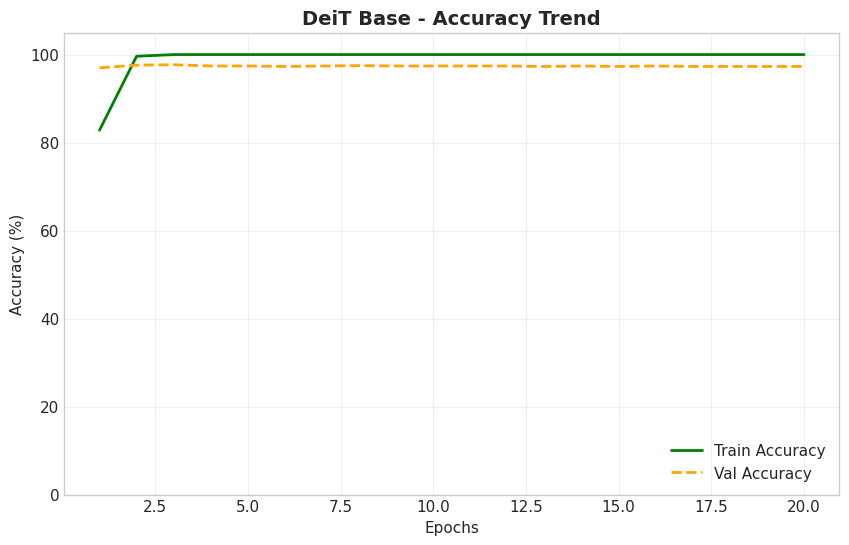

[SAVED] DeiT_Base_Accuracy_Trend.png
[SAVED] ViT_Base_Loss_Trend.png


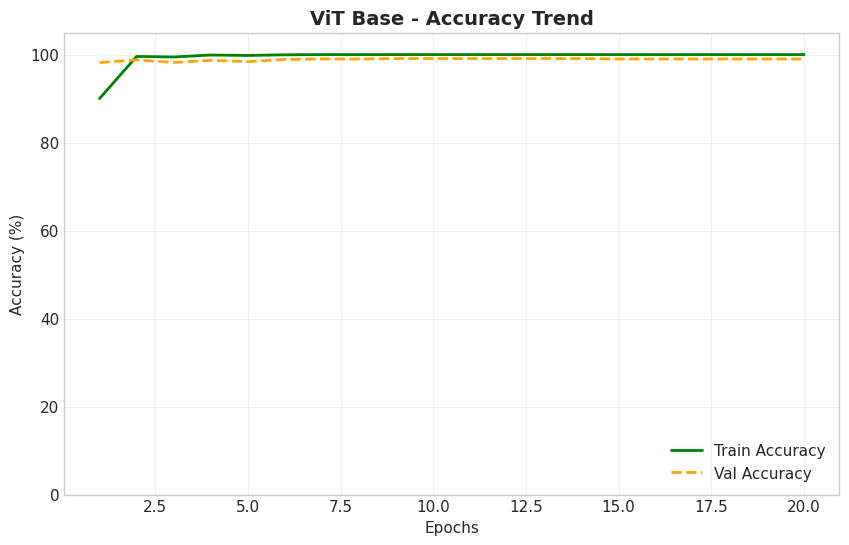

[SAVED] ViT_Base_Accuracy_Trend.png
[SAVED] Swin_Base_Loss_Trend.png


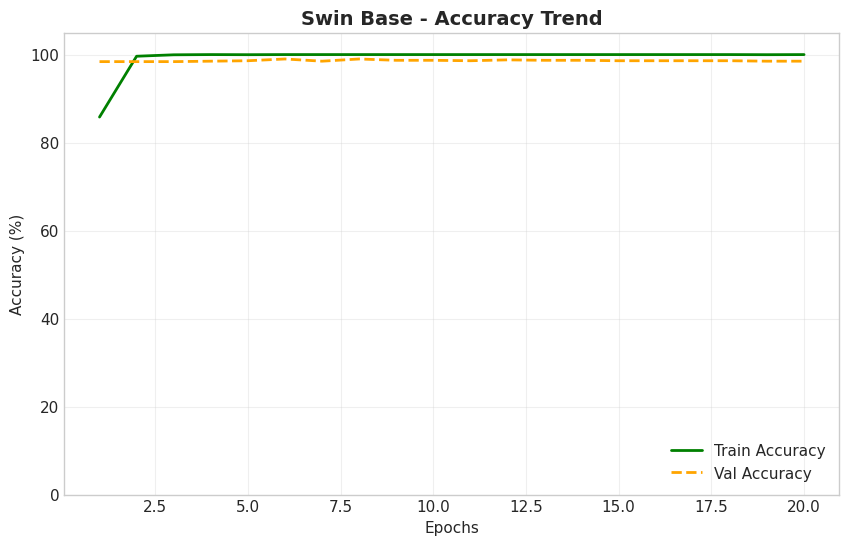

[SAVED] Swin_Base_Accuracy_Trend.png

[INFO] Semua 6 gambar tersimpan di folder: ./training_results/run_20251121_134130/plots/individual_curves


In [ ]:
import matplotlib.pyplot as plt
import os

if len(results_store) > 0:
    print("\n" + "="*60)
    print("2. GENERATING INDIVIDUAL LEARNING CURVES (6 IMAGES)")
    print("="*60)

    # Buat folder khusus agar rapi
    split_plot_dir = f"{OUTPUT_DIR}/plots/individual_curves"
    os.makedirs(split_plot_dir, exist_ok=True)

    for name, data in results_store.items():
        # Ubah nama model agar aman untuk nama file (spasi jadi underscore)
        safe_name = name.replace(" ", "_")
        
        hist = data['history']
        ep_range = range(1, len(hist['train_loss'])+1)
        
        # ---------------------------------------
        # A. GAMBAR 1: LOSS TREND
        # ---------------------------------------
        plt.figure(figsize=(10, 6))
        plt.plot(ep_range, hist['train_loss'], 'b-', label='Train Loss', linewidth=2)
        plt.plot(ep_range, hist['val_loss'], 'r--', label='Val Loss', linewidth=2)
        
        plt.title(f'{name} - Loss Trend', fontsize=14, fontweight='bold')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        
        # Simpan File Loss
        loss_filename = f"{safe_name}_Loss_Trend.png"
        loss_path = os.path.join(split_plot_dir, loss_filename)
        plt.savefig(loss_path, dpi=300, bbox_inches='tight')
        plt.close() # Penting: Tutup plot agar memori tidak bocor
        print(f"[SAVED] {loss_filename}")

        # ---------------------------------------
        # B. GAMBAR 2: ACCURACY TREND
        # ---------------------------------------
        plt.figure(figsize=(10, 6))
        plt.plot(ep_range, hist['train_acc'], 'g-', label='Train Accuracy', linewidth=2)
        plt.plot(ep_range, hist['val_acc'], 'orange', linestyle='--', label='Val Accuracy', linewidth=2)
        
        plt.title(f'{name} - Accuracy Trend', fontsize=14, fontweight='bold')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.ylim(bottom=0, top=105) # Set batas Y agar grafik terlihat jelas
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        
        # Simpan File Accuracy
        acc_filename = f"{safe_name}_Accuracy_Trend.png"
        acc_path = os.path.join(split_plot_dir, acc_filename)
        plt.savefig(acc_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"[SAVED] {acc_filename}")

    print(f"\n[INFO] Semua 6 gambar tersimpan di folder: {split_plot_dir}")


3. GENERATING INDIVIDUAL CONFUSION MATRICES (3 IMAGES)


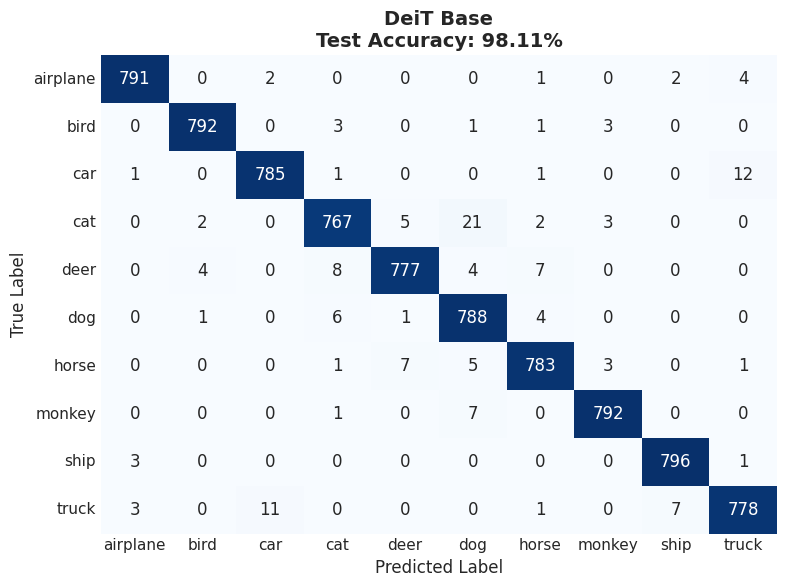

[SAVED] DeiT_Base_Confusion_Matrix.png


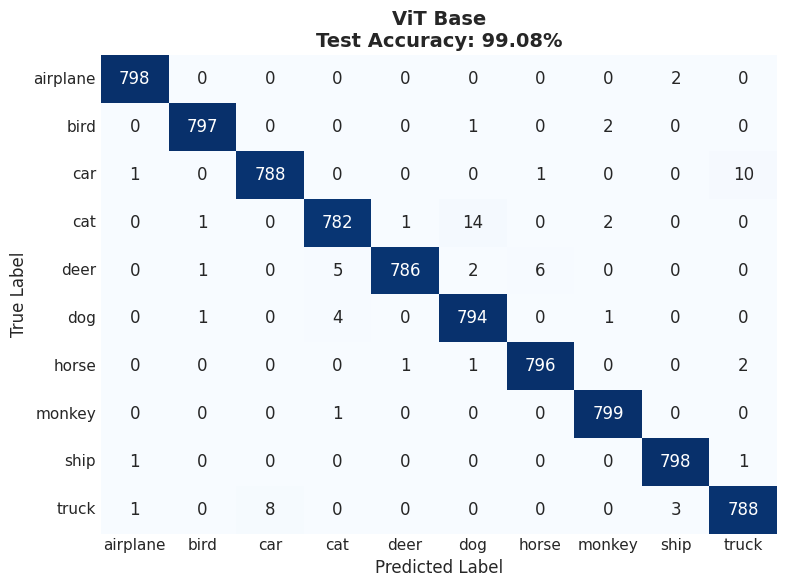

[SAVED] ViT_Base_Confusion_Matrix.png


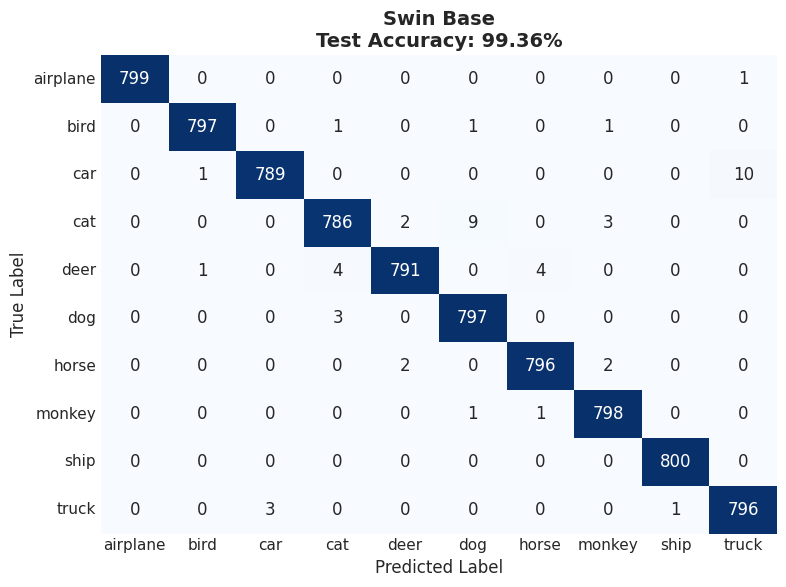

[SAVED] Swin_Base_Confusion_Matrix.png

[INFO] Semua 3 gambar Confusion Matrix tersimpan di folder: ./training_results/run_20251121_134130/plots/individual_cm


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

if len(results_store) > 0:
    print("\n" + "="*60)
    print("3. GENERATING INDIVIDUAL CONFUSION MATRICES (3 IMAGES)")
    print("="*60)

    # Buat folder khusus agar rapi
    cm_plot_dir = f"{OUTPUT_DIR}/plots/individual_cm"
    os.makedirs(cm_plot_dir, exist_ok=True)

    for name, data in results_store.items():
        # Ubah nama model agar aman untuk nama file
        safe_name = name.replace(" ", "_")
        
        cm = data['cm']
        acc = data["metrics"]["accuracy"] * 100
        
        # Buat Figure Baru untuk setiap model
        plt.figure(figsize=(8, 6))
        
        # Plot Heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names, 
                    cbar=False, annot_kws={"size": 12})
        
        plt.title(f'{name}\nTest Accuracy: {acc:.2f}%', fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        
        plt.tight_layout()
        
        # Simpan File
        cm_filename = f"{safe_name}_Confusion_Matrix.png"
        save_path = os.path.join(cm_plot_dir, cm_filename)
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"[SAVED] {cm_filename}")

    print(f"\n[INFO] Semua 3 gambar Confusion Matrix tersimpan di folder: {cm_plot_dir}")